## Построение модели классификации

### Подключение библиотек  и скриптов

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#import xgboost as xgb
#import lightgbm as lgbm
import catboost as catb
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

### Обзор обучающего датасета

In [2]:
# Пути к файлам датасета
TRAIN_PATH = 'Downloads/course_project/course_project_train.csv'
TEST_PATH = 'Downloads/course_project/course_project_test.csv'

In [3]:
# Загрузка данных
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

In [4]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
df_train.shape

(7500, 17)

In [6]:
df_train.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
Name: 0, dtype: object

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [8]:
# Есть пропуски в Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit score

In [9]:
# Выделение целевой переменной и базовых признаков
target_name = 'Credit Default'
base_feature_names = df_train.columns.drop(target_name).tolist()

## Обзор данных

### Обзор целевой переменной

In [10]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обзор количественных признаков

In [11]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


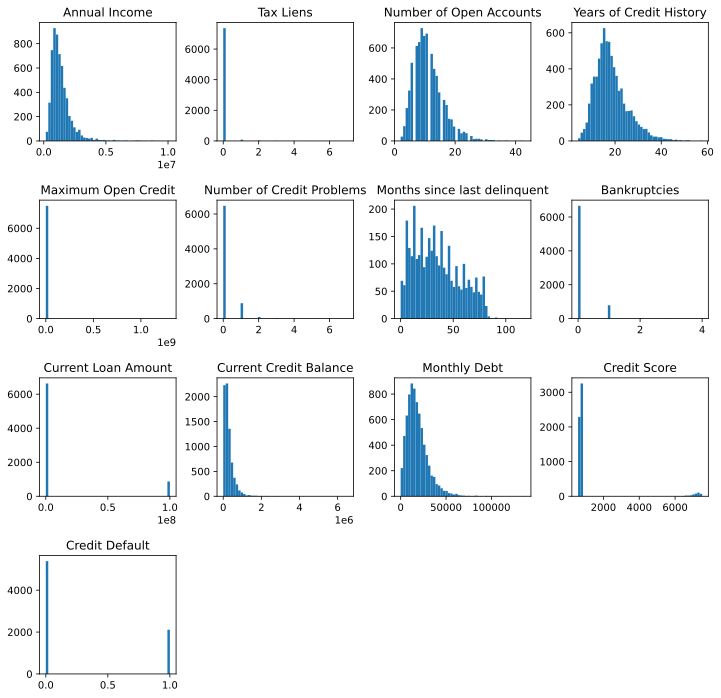

In [12]:
# Визуальное распределение колличественных признаков
feature_names = df_train.columns

df_train[feature_names].hist(figsize=(12, 12), bins=50, grid=False)
plt.subplots_adjust(hspace=0.5)

plt.show()

In [13]:
# Annual Income выброс от 0,5 
# Tax Liens оставить 0 не было и 1 было
# Number of open accounts выброс от 30
# Years of credit history выброс после 50
# Maximum open credit выброс от 0.3
# Number of credit problems оставить 0 не было и 1 были
# Months since last delinquent выброс от 100
# Bankruptcies оставить 0 не было и 1 было
# Current Loan Amount выброс в районе 1 
# Current Credit Balance выбросы от 3
# Monthly Debt выбросы от 100000
# Credit score выбросы от 6000

## Корреляция признаков

In [14]:
df_train.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
Annual Income,1.00,0.07,0.19,0.19,0.06,-0.02,-0.10,-0.07,0.03,0.39,0.58,-0.04,-0.10
Tax Liens,0.07,1.00,-0.01,0.01,-0.00,0.60,0.05,0.06,-0.01,-0.01,0.03,0.01,0.02
Number of Open Accounts,0.19,-0.01,1.00,0.14,0.02,-0.02,-0.03,-0.02,0.00,0.27,0.41,0.02,0.03
Years of Credit History,0.19,0.01,0.14,1.00,0.03,0.07,-0.02,0.09,0.01,0.22,0.19,-0.02,-0.02
Maximum Open Credit,0.06,-0.00,0.02,0.03,1.00,-0.00,-0.00,-0.01,-0.00,0.09,0.01,-0.01,-0.01
Number of Credit Problems,-0.02,0.60,-0.02,0.07,-0.00,1.00,0.14,0.73,-0.01,-0.12,-0.04,-0.02,0.02
Months since last delinquent,-0.10,0.05,-0.03,-0.02,-0.00,0.14,1.00,0.16,0.00,-0.03,-0.06,-0.00,0.00
Bankruptcies,-0.07,0.06,-0.02,0.09,-0.01,0.73,0.16,1.00,-0.01,-0.14,-0.08,-0.03,0.00
Current Loan Amount,0.03,-0.01,0.00,0.01,-0.00,-0.01,0.00,-0.01,1.00,0.02,-0.01,-0.11,-0.23
Current Credit Balance,0.39,-0.01,0.27,0.22,0.09,-0.12,-0.03,-0.14,0.02,1.00,0.50,-0.01,-0.02


In [15]:
# Наибольшее влияние на целевую переменную
df_train.corr()['Credit Default'].sort_values(ascending=False)

Credit Default                  1.000000
Credit Score                    0.442050
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Number of Credit Problems       0.020088
Monthly Debt                    0.018480
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Maximum Open Credit            -0.014275
Current Credit Balance         -0.019522
Years of Credit History        -0.020567
Annual Income                  -0.101375
Current Loan Amount            -0.226522
Name: Credit Default, dtype: float64

### Обзор номинативных признаков

In [16]:
# Обзор признаков в trein
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '_' * 50 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
__________________________________________________

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
__________________________________________________

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64
________________________

In [17]:
# Home Ownership возможно have mortgage и home mortgage имеют одинаковый смысл. Переименуем have в home
# Home Ownership, Years in current job, Purpose сделать dummie
# Term заменить на Short_Term где 1 - да, short и 0 - нет, long term

In [18]:
# Обзор признаков в test
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '_' * 50 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
__________________________________________________

Years in current job

10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
__________________________________________________

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
educational expenses       3
vacation                   3
wedding                    2
moving                     1
Name: Purpose, dtype: int64
__________________________________________________

Term

Short 

## Обработка пропусков

In [19]:
# Поиск пропусков train
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [20]:
#Замена пропусков на медианы train
df_train['Annual Income'].fillna(df_train['Annual Income'].median(), inplace=True)
df_train['Years in current job'].fillna('x years', inplace=True)
df_train['Months since last delinquent'].fillna(df_train['Months since last delinquent'].median(), inplace=True)
df_train['Credit Score'].fillna(df_train['Credit Score'].median(), inplace=True)
df_train['Bankruptcies'].fillna(df_train['Bankruptcies'].median(), inplace=True)

In [21]:
# поиск пропусков test
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [22]:
#Замена пропусков на медианы test
df_test['Annual Income'].fillna(df_test['Annual Income'].median(), inplace=True)
df_test['Years in current job'].fillna('x years', inplace=True)
df_test['Months since last delinquent'].fillna(df_test['Months since last delinquent'].median(), inplace=True)
df_test['Credit Score'].fillna(df_test['Credit Score'].median(), inplace=True)
df_test['Bankruptcies'].fillna(df_test['Bankruptcies'].median(), inplace=True)

## Обработка выбросов

### Home Ownership

In [23]:
df_train.loc[df_train['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

df_test.loc[df_test['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage'

### Purpose

In [24]:
df_train.loc[df_train['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

df_test.loc[df_test['Purpose'] != 'debt consolidation', 'Purpose'] = 'other'

## Построение новых признаков

### ID

In [25]:
df_train['ID'] = df_train.index.tolist()

df_test['ID'] = df_test.index.tolist()

In [26]:
df_train.dtypes

Home Ownership                   object
Annual Income                   float64
Years in current job             object
Tax Liens                       float64
Number of Open Accounts         float64
Years of Credit History         float64
Maximum Open Credit             float64
Number of Credit Problems       float64
Months since last delinquent    float64
Bankruptcies                    float64
Purpose                          object
Term                             object
Current Loan Amount             float64
Current Credit Balance          float64
Monthly Debt                    float64
Credit Score                    float64
Credit Default                    int64
ID                                int64
dtype: object

### Dummies

In [27]:
df_train['Short_term'] = df_train['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

df_test['Short_term'] = df_test['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [28]:
for cat_colname in df_train.select_dtypes(include='object').columns[:]:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[cat_colname], prefix=cat_colname)], axis=1)
    
for cat_colname in df_test.select_dtypes(include='object').columns[:]:
    df_test = pd.concat([df_test, pd.get_dummies(df_test[cat_colname], prefix=cat_colname)], axis=1)    

In [29]:
# Сохранение списка новых признаков
new_feature_names = df_train.columns.drop([target_name] + base_feature_names).tolist()

## Анализ целевой переменной

### Обзор распределения

In [30]:
df_train[target_name].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

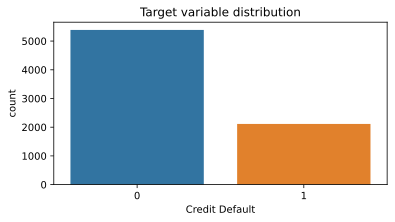

In [31]:
plt.figure(figsize=(6, 3))

sns.countplot(x=target_name, data=df_train)

plt.title('Target variable distribution')
plt.show()

## Корреляция с базовыми признаками

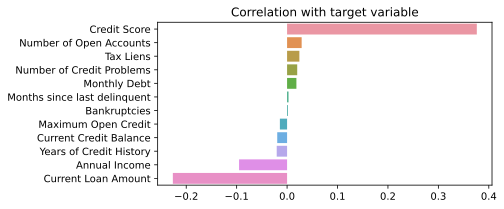

In [32]:
corr_with_target = df_train[base_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(6, 3))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Оценка признака Credit Score в разрезе целевой переменной

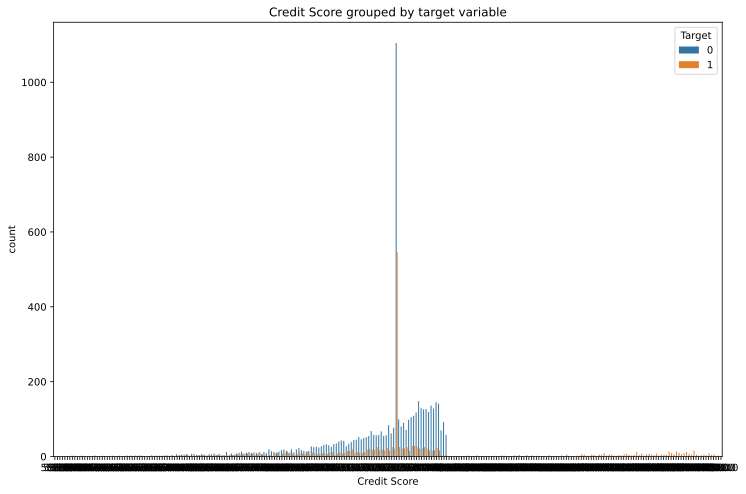

In [33]:
plt.figure(figsize=(12, 8))

sns.countplot(x='Credit Score', hue=target_name, data=df_train)
plt.title('Credit Score grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [34]:
# На графике видно что значения Credit Score выше 6000 имеют показатель целевой переменной равный 1.

### Оценка признака Current Loan Amount в разрезе целевой переменной

No handles with labels found to put in legend.


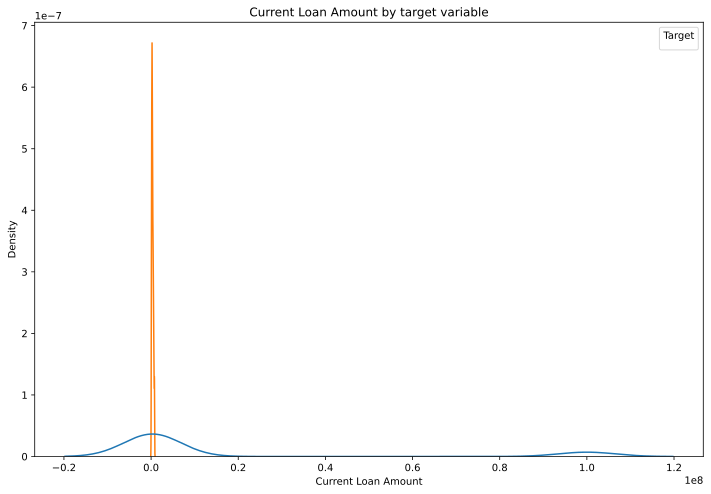

In [35]:
plt.figure(figsize=(12, 8))

sns.kdeplot(x='Current Loan Amount', hue=target_name, data=df_train)
plt.title('Current Loan Amount by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [36]:
# На графике видно что значения Curren Loan Amount больше 0.8 не содержат целевую переменную

### Корреляция по всем признакам

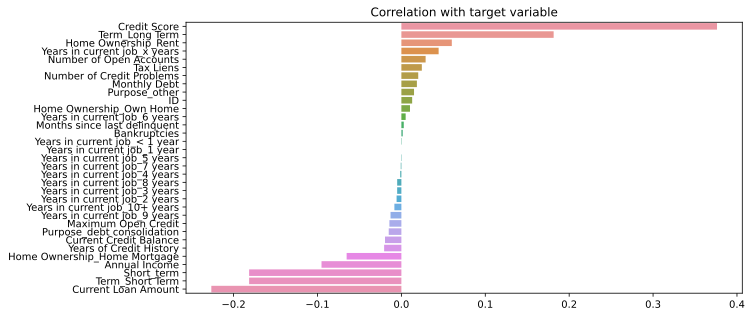

In [37]:
corr_with_target = df_train[base_feature_names + new_feature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 5))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Анализ признакового пространства

### Матрица корреляций

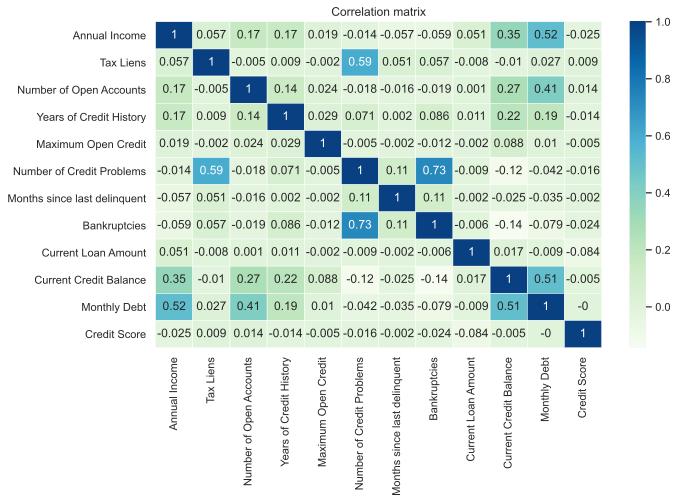

In [38]:
# Корреляция между базовыми признаками
plt.figure(figsize = (10,6))

sns.set(font_scale=1.0)
sns.heatmap(df_train[base_feature_names].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

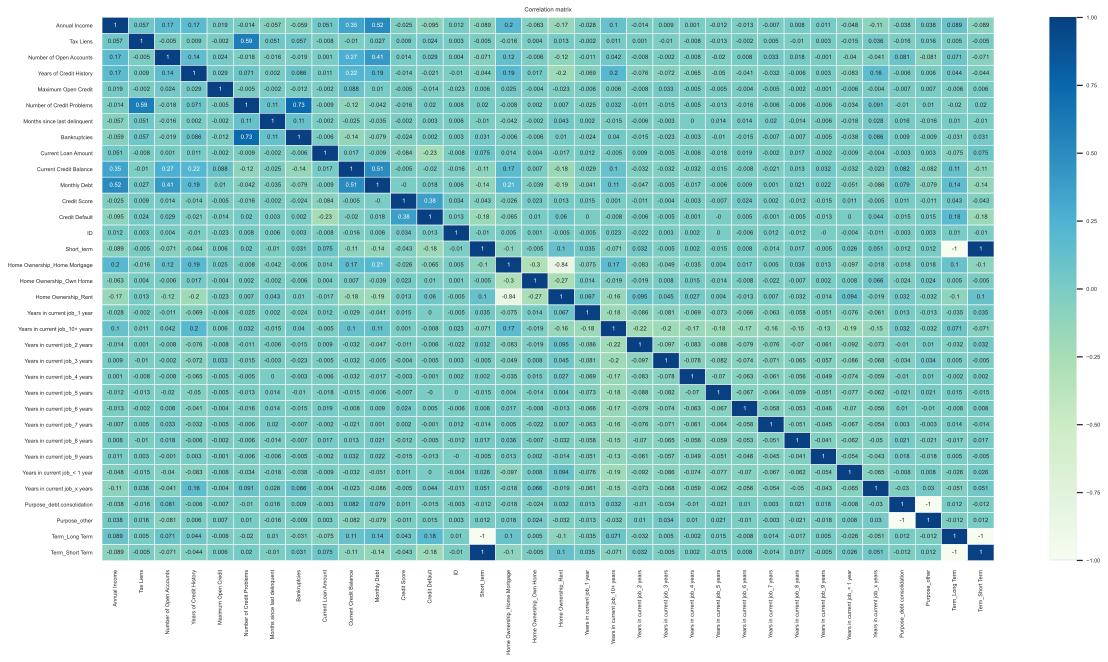

In [39]:
# Корреляция по всем признакам
plt.figure(figsize = (20,10))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

In [40]:
# Вывод: целевая переменная Credit Default наиболее коррелирует с Credit Score и Term_Long_term

### Подготовка скриптов

In [41]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [42]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

### Отбор признаков

In [43]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Months since last delinquent', 'Current Loan Amount', 
                     'Current Credit Balance', 'Monthly Debt', 'Credit Score']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term', 'Tax Liens', 
                     'Number of Credit Problems', 'Bankruptcies']
                     
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + new_feature_names

### Приведение типов для модели CatBoost

In [44]:
for colname in CAT_FEATURE_NAMES:
    df_train[colname] = pd.Categorical(df_train[colname])

for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])
    
df_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Purpose                      category
Term                         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
dtype: object

### Нормализация данных

In [45]:
scaler = StandardScaler()

df_train_norm = df_train.copy()
df_train_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUM_FEATURE_NAMES])

df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])

df = df_train_norm.copy()

### Разбиение на train и test

In [46]:
X = df[SELECTED_FEATURE_NAMES]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [47]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [48]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

## Построение и оценка базовых моделей

### Логистическая регрессия

In [49]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.68      0.83      0.75      3771
           1       0.71      0.51      0.59      2958

    accuracy                           0.69      6729
   macro avg       0.69      0.67      0.67      6729
weighted avg       0.69      0.69      0.68      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1616
           1       0.53      0.50      0.51       634

    accuracy                           0.73      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1327  289
1                314  320


/Users/ivanplyavin/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### k ближайших соседей

In [50]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      3771
           1       0.76      0.62      0.68      2958

    accuracy                           0.75      6729
   macro avg       0.75      0.73      0.74      6729
weighted avg       0.75      0.75      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.73      0.72      0.72      1616
           1       0.31      0.32      0.32       634

    accuracy                           0.61      2250
   macro avg       0.52      0.52      0.52      2250
weighted avg       0.61      0.61      0.61      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1159  457
1                430  204


### CatBoost

In [51]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      3771
           1       0.95      0.88      0.91      2958

    accuracy                           0.92      6729
   macro avg       0.93      0.92      0.92      6729
weighted avg       0.93      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1616
           1       0.56      0.47      0.51       634

    accuracy                           0.75      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.74      0.75      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1385  231
1                335  299


### Выбор лучшей модели и подбор гиперпараметров

In [52]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

### Подбор гиперпараметров

In [53]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7, 9]}

In [54]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [55]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

CPU times: user 13.1 s, sys: 1.27 s, total: 14.3 s
Wall time: 1min 18s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fa3c465a9d0>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7, 9],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [56]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 3}

In [57]:
rs.best_score_

0.5410482419900279

## Обучение и оценка финальной модели

In [66]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=3,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3771
           1       0.80      0.65      0.72      2958

    accuracy                           0.78      6729
   macro avg       0.78      0.76      0.77      6729
weighted avg       0.78      0.78      0.77      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      1616
           1       0.54      0.51      0.53       634

    accuracy                           0.74      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1337  279
1                309  325
CPU times: user 11.4 s, sys: 852 ms, total: 12.3 s
Wall time: 3.15 s


### Подбор оптимального размера выборки, кривая обучения

In [67]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

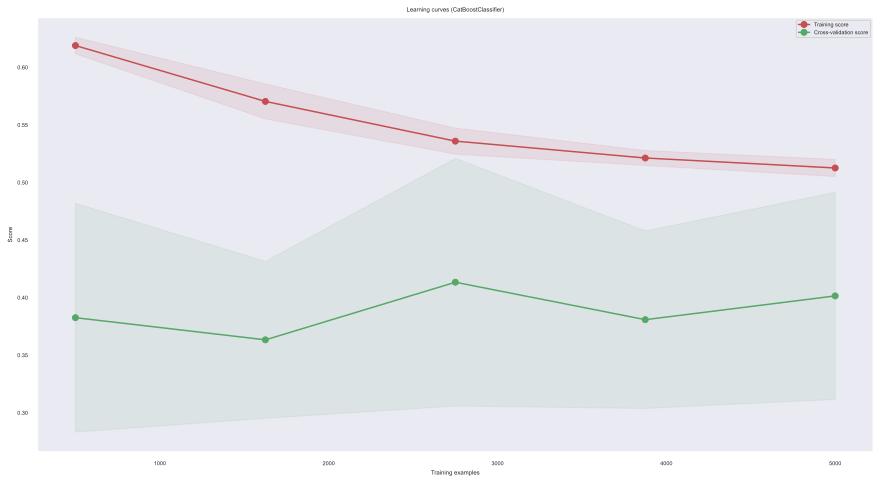

In [68]:
show_learning_curve_plot(final_model, X, y)

### Выбор порога вероятности для определения класса

In [69]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (12, 6))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

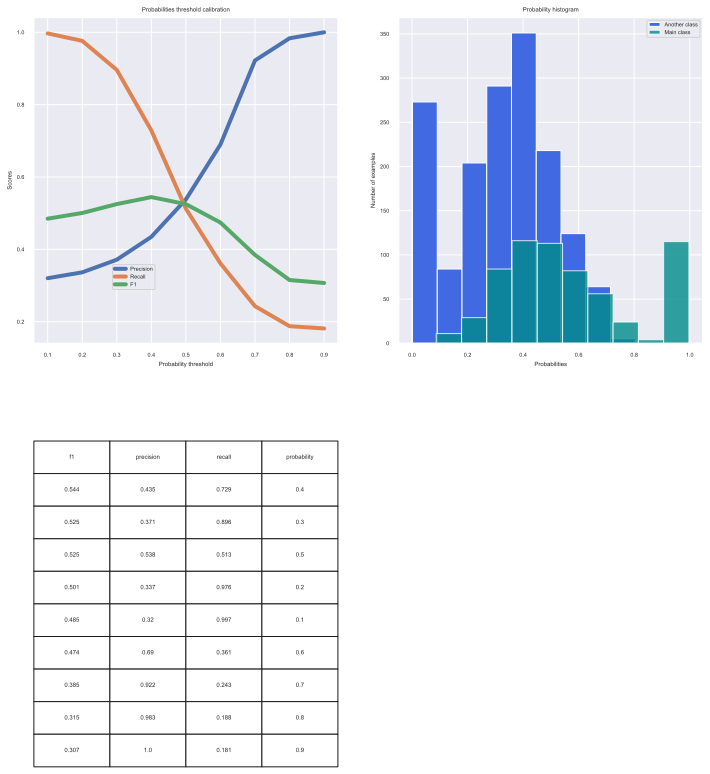

In [70]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Финальное предсказание

In [71]:
credit_default_pred = final_model.predict(df_test_norm[SELECTED_FEATURE_NAMES])

credit_default_pred

array([1, 1, 1, ..., 1, 0, 1])

In [73]:
preds_final = pd.DataFrame()
preds_final = pd.DataFrame({'ID': np.arange(0,credit_default_pred.shape[0]), 'Credit Default': credit_default_pred})
preds_final.to_csv('./predictions.csv', index=False, encoding='utf-8', sep=',')
preds_final.head(10)

,ID,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,0
6,6,1
7,7,1
8,8,1
9,9,0
